<a href="https://colab.research.google.com/github/shokru/carbon_emissions/blob/main/gdp_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Economic output and temperature dynamics

In [24]:
import pandas as pd                      # This library is for data wrangling
import seaborn as sns                    # This is one library for plotting
import matplotlib.pyplot as plt          # Yet another library for visualization
import plotly.express as px              # This is another library for plots 
pd.set_option('display.max_rows', 6)     # First 3 and last 3 rows will be shown
import warnings                          # This is to remove warning to keep output clean
warnings.filterwarnings('ignore')

## Temperature data

First, let's download global annual temperatures from the NASA (see the page https://climate.nasa.gov/vital-signs/global-temperature/).  
The values related to the difference with pre-industrial periods.  
This is often taken to be 1850-1900, though it's unclear if this is the base choice in the NASA's data.

In [36]:
url = 'https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt'
data_temp = pd.read_csv(url, skiprows = 4, sep='\r\t')  
data_temp = data_temp.iloc[0:,0].str.split(expand = True)
data_temp = data_temp.rename(columns = {0: 'Year', 1: 'Temperature', 2: 'Smoothing'})
data_temp['Temperature'] = pd.to_numeric(data_temp['Temperature']) # Translate to number
data_temp['Smoothing'] = pd.to_numeric(data_temp['Smoothing'])     # Translate to number
data_temp['Year'] = pd.to_numeric(data_temp['Year'])               # Translate to number
data_temp

,Year,Temperature,Smoothing
0,1880,-0.16,-0.09
1,1881,-0.08,-0.12
2,1882,-0.10,-0.16
...,...,...,...
138,2018,0.85,0.94
139,2019,0.98,0.98
140,2020,1.02,1.01


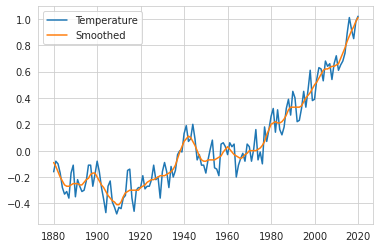

In [37]:
plt.plot(data_temp.Year, data_temp.Temperature, label = "Temperature")
plt.plot(data_temp.Year, data_temp.Smoothing, label = "Smoothed")
plt.legend()
plt.show()


The trend post-1960 seems pretty obvious (almost post-1900 if we omit World War II).

Next, GDP data from the **World Bank**.

In [ ]:
url = 'https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=excel'
data_gdp = pd.read_excel(url, skiprows = 3) 
# Putting the data in long format below
data_gdp = pd.wide_to_long(data_gdp.iloc[0:,0:65], 
                stubnames = [''], 
                i = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                j = 'Year').reset_index()
data_gdp = data_gdp.rename(columns = {'Country Name': 'Country', '': 'GDP'})
data_gdp

# Conclusion

Economic output and rising temperatures are **linked**. While our analysis is not sufficient to prove **causality**, there is strong consensus among the scientific community that global warming stems from human activity (even via cattle!).  
An important note: temperature is not the only relevant indicator. **Precipitation** (& humidity) is another facet of climate that is impacted by GHG emissions. The recent trends show extreme dynamics: dry places become drier and "wet" areas experience more and more intense rain episodes.